In [12]:
#imports
import pandas as pd
import time
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from models import naive_bayes, logistic, random_forest, k_cross_val
from scipy.sparse import csr_matrix, hstack

import itertools
import random

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt

In [3]:
# import the data
data = pd.read_csv('data/clean_data.csv',index_col = 0)

Based on the results from the initial model fitting, it seems as though the numerical features we collected using Tweepy were not particularly useful. This could be because the features themselves are not informative or because the imputation techniques we used for the missing tweets were not good. If we have time, we can go back and try more advanced imputation techniques. For now, let's ignore the imputed numerical features except for date_time. Date_time should be reliable because tweets are organized chronologically by tweet id and so the missing date_times we imputed should be fairly reliable. Let's also keep numerical features that we collected directly from the text like exclamation_mark_count.

In [4]:
# adding date time features
data['date_time'] = pd.to_datetime(data['date_time'])
data['month'] = data['date_time'].dt.month
data['hour'] = data['date_time'].dt.hour
data['dayofweek'] = data['date_time'].dt.dayofweek
data.iloc[[0]]

,clean text,tweetid,is_retweet,is_quoted,date_time,retweets,favorites,followers,verified,location,exclamation_mark_count,question_mark_count,imputed,sentiment,month,hour,dayofweek
2,aaaaaand delet glob warm rain tweet cas miss s...,794050846807982080,1,0,2016-11-03 05:37:29,47,79,20106,1,NYC,0,0,False,-1,11,5,3


In [19]:
# upsampling seemed to improve results so let's continue doing this

n = len(data)
print('Initial class distribution')
print('class 1: ', len(data[data['sentiment']==1])/n)
print('class 0: ', len(data[data['sentiment']==0])/n)
print('class -1: ', len(data[data['sentiment']==-1])/n)

np.random.seed(123)

diffneg = (len(data[data['sentiment']==1]) - 
        len(data[data['sentiment']==-1])) # want to creat 33-33-33 balance
diffneu = (len(data[data['sentiment']==1]) - 
        len(data[data['sentiment']==0])) # want to creat 33-33-33 balance

neg_data = data[data['sentiment']==-1] # sample to choose from
neu_data = data[data['sentiment']==0] # sample to choose from

upsample_index_neg = np.random.choice(neg_data.index,size=diffneg) # sample with repetition
upsample_index_neu = np.random.choice(neu_data.index,size=diffneu) # sample with repetition

data_ups = data.append(neg_data.loc[upsample_index_neg]).append(neu_data.loc[upsample_index_neu]).sample(frac=1)

n = len(data_ups)
print('Upsampled class distribution')
print('class 1: ', len(data_ups[data_ups['sentiment']==1])/n)
print('class 0: ', len(data_ups[data_ups['sentiment']==0])/n)
print('class -1: ', len(data_ups[data_ups['sentiment']==-1])/n)

Initial class distribution
class 1:  0.6481264232972189
class 0:  0.22859015940928853
class -1:  0.12328341729349251
Upsampled class distribution
class 1:  0.3333333333333333
class 0:  0.3333333333333333
class -1:  0.3333333333333333


## Random Forest

### Part 1: Feature Selection

In [7]:
#split data into testing and training sets 
X_train, X_test, y_train, y_test = train_test_split(data_ups.drop(labels = "sentiment", axis = 1), 
                                                    data_ups["sentiment"], test_size=0.2, 
                                                    random_state=0)

In [8]:
# select just the numerical data
numerical_feature_names = ['exclamation_mark_count', 'question_mark_count','month','hour','dayofweek']
X_train_numerical = X_train.loc[:,numerical_feature_names]

In [11]:
# compare 5 fold cross validation error metrics for count and tfidf vectorizer with
# 1, 2, 3-grams

for skvectorizeri in [CountVectorizer,TfidfVectorizer]:
    print(skvectorizeri)
    for ngrami in [(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]:
        rf = random_forest(X_train["clean text"].values, y_train.values, X_train_numerical.values,
                           ngram=ngrami,skvectorizer=skvectorizeri)
        print('n-gram: ',ngrami)
        print('Accuracy: ',rf[0])
        print('Precision: ',rf[1])
        print('Recall: ',rf[2])
        print('F score: ',rf[3])

<class 'sklearn.feature_extraction.text.CountVectorizer'>
n-gram:  (1, 1)
Accuracy:  0.8962756265671498
Precision:  0.8971316026935282
Recall:  0.8963747930448666
F score:  0.8952602867572047
n-gram:  (1, 2)
Accuracy:  0.8921496923045584
Precision:  0.89496521274199
Recall:  0.8922580278359604
F score:  0.8911518410132888
n-gram:  (1, 3)
Accuracy:  0.8909296981084432
Precision:  0.8945634687950432
Recall:  0.891035682712479
F score:  0.8899493985250444
n-gram:  (2, 2)
Accuracy:  0.8900424038828756
Precision:  0.8918710181642598
Recall:  0.8901701293288931
F score:  0.8897688771811273
n-gram:  (2, 3)
Accuracy:  0.8864266983029886
Precision:  0.8883014053458954
Recall:  0.8865457950462232
F score:  0.8858787897968792
n-gram:  (3, 3)
Accuracy:  0.8554601561538252
Precision:  0.8624233906219041
Recall:  0.8556111031621623
F score:  0.8528549248367756
<class 'sklearn.feature_extraction.text.TfidfVectorizer'>
n-gram:  (1, 1)
Accuracy:  0.9022648853457224
Precision:  0.9021834624408583
Recall

TFIDF vectorizer with 1-grams had the best performance.

Random forests perform implicit feature selection by splitting on the most important nodes, but it can still be useful to look at which features it deemed the most important if we want to speed up the model (especially if performing hyperparameter optimization) and potentially use as feature selection for other models. Two things to note:
- random forests are biased towards features with high cardinality (more categories)
- if there are correlated features, one of them will cary most of the importance because once a node splits on a feature the other correlated features will not offer much new information

In [14]:
# create feature matrix
vectorizer = TfidfVectorizer(ngram_range=(1,1))
features = vectorizer.fit_transform(X_train["clean text"].values)
features = hstack([features, csr_matrix(X_train_numerical.values)])

# 5 fold cross validation on training data
start = time.time()
rf_classifier = RandomForestClassifier()
errors = k_cross_val(rf_classifier,features.tocsr(),y_train.values,k=5)
stop = time.time()

print('time:',stop-start)
print(errors)

time: 402.688111782074
(0.9011557829394325, 0.9014004984030946, 0.9012790371225587, 0.9004411015154868)


In [20]:
# https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
rf_classifier = RandomForestClassifier()
rf_classifier.fit(features, y_train) # fit model to all training data

feature_names = vectorizer.get_feature_names() + numerical_feature_names
importances = list(rf_classifier.feature_importances_) # higher value = more important
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_names, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
for i in range(25): # print top 25 most important features
    print('feature:', feature_importances[i][0],' | ',feature_importances[i][1])

feature: chang  |  0.02229
feature: clim  |  0.02086
feature: hour  |  0.01712
feature: month  |  0.01483
feature: warm  |  0.01455
feature: glob  |  0.01443
feature: dayofweek  |  0.01363
feature: deny  |  0.0077
feature: lib  |  0.00732
feature: sci  |  0.00615
feature: scam  |  0.00599
feature: obam  |  0.00532
feature: real  |  0.00496
feature: trump  |  0.00488
feature: exclamation_mark_count  |  0.0045
feature: fight  |  0.00397
feature: believ  |  0.00394
feature: mad  |  0.00383
feature: man  |  0.00376
feature: alarm  |  0.00351
feature: question_mark_count  |  0.00348
feature: fak  |  0.00345
feature: hoax  |  0.00345
feature: left  |  0.00339
feature: say  |  0.00326


A lot of these features make sense! There are many words related to climate change (chang, clim, warm, glob), belief (deny, scam, real, believ, fak, hoax), and politcs (lib, obam, trump). It's also intersting to note that all our numerical features were pretty important.

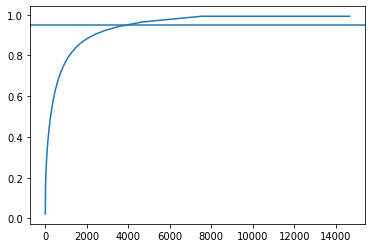

In [16]:
plt.plot(np.arange(len(feature_importances)),np.cumsum(np.array([tup[1] for tup in feature_importances])))
plt.axhline(.95)

In [17]:
n95 = len(feature_importances) - sum(np.cumsum(np.array([tup[1] for tup in feature_importances]))>.95)
print('The number of features that capture 95% of the importance: ',n95)
indices95 = np.argsort(-np.array(importances))[:n95]

# train model on all training data
features95 = features.tocsr()[:,indices95]

# 5 fold cross validation on training data
start = time.time()
rf_classifier = RandomForestClassifier()
errors = k_cross_val(rf_classifier,features95,y_train.values,k=5)
stop = time.time()

print('time:',stop-start)
print(errors)

The number of features that capture 95% of the importance:  3933
time: 194.70488381385803
(0.8944566725436985, 0.8950586105274384, 0.8946028264713585, 0.8934377683074354)


### Hyperparameter Optimization

In [1]:
# n_estimators integer, optional (default=100)
# max_depth integer or None, optional (default=None)
# min_samples_split int, float, optional (default=2)
# min_samples_leaf int, float, optional (default=1)

n_estimators_array = [100, 200, 400, 600, 800, 1000]
max_depth_array = [200,400,600,800, None]
min_samples_split_array = [2,5,10]
min_samples_leaf_array = [1,2,4]

param = [n_estimators_array,max_depth_array,min_samples_split_array,min_samples_leaf_array]
param_grid = list(itertools.product(*param))  
for p in random.sample(param_grid,20):
    rf_classifier = RandomForestClassifier(n_estimators=p[0], max_depth=p[1], min_samples_split=p[2], min_samples_leaf=p[3])
    errors = k_cross_val(rf_classifier,features95,y_train.values,k=5)
    print(p," | ",errors)

'n_estimators_array = [100, 200, 400, 600, 800, 1000]\nmax_depth_array = [200,400,600,800, None]\nmin_samples_split_array = [2,5,10]\nmin_samples_leaf_array = [1,2,4]\n\nparam = [n_estimators_array,max_depth_array,min_samples_split_array,min_samples_leaf_array]\nparam_grid = list(itertools.product(*param))  \nfor p in random.sample(param_grid,20):\n    rf_classifier = RandomForestClassifier(n_estimators=p[0], max_depth=p[1], min_samples_split=p[2], min_samples_leaf=p[3])\n    errors = k_cross_val(rf_classifier,features95,y_train.values,k=5)\n    print(p," | ",errors)'

In [ ]:
# this takes too long locally
# will likely use the computing resources of something like AWS to run this